<a href="https://colab.research.google.com/github/PratikhyaManas/Detectron2_ObjectDetection/blob/master/VehicleDetection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vehicle Detection with Detectron2**

# **Install Dependencies**

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 14.9MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=f9004313e4dd7e479834c7ce3a1f4d3db55aa42b7b90f23dfb59ae0c6c78ddb7
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 26.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200506-cp36-none-any.whl size=40569 sha256=b34d54e29b5e2090165ec13b80de66f07432a48b2b890fee92073f508d48309d
  Stored in directory: /root/.cache/pip/wheels/3f/db/ab/307827ba85b8cc1d288f096909499ecdbcac90db4edaa088fe
Successfully built fvcore


# **Import Data**

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2020-05-06 09:44:14--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz’

object-detection-cr 100%[===================>]   1.54G  16.8MB/s    in 99s     

2020-05-06 09:45:54 (15.9 MB/s) - ‘object-detection-crowdai.tar.gz’ saved [1650810880/1650810880]

--2020-05-06 09:45:55--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7156250 (6.8M) [text/plain]
S

In [0]:
!tar xf object-detection-crowdai.tar.gz

In [6]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

xmin  ymin  ...  Label                                        Preview URL
0   785   533  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1    89   551  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2   268   546  ...    Car  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3   455   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4   548   522  ...  Truck  http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...

[5 rows x 7 columns]

# **Register the Data**

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

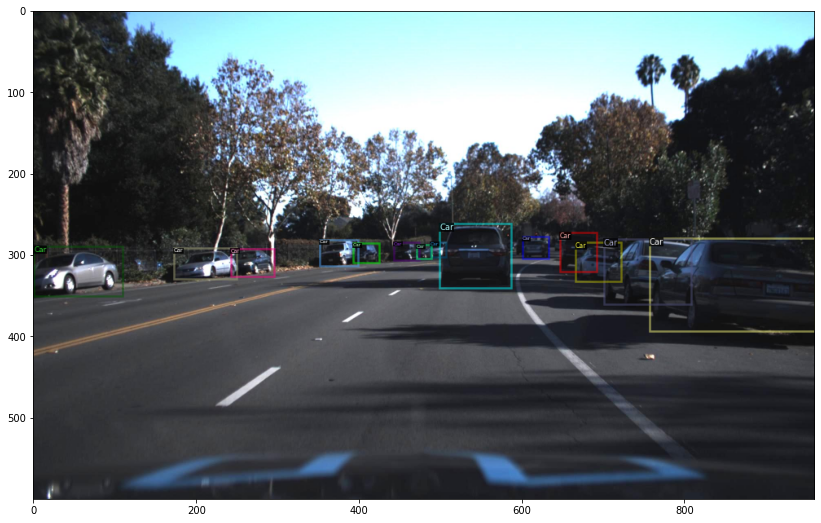

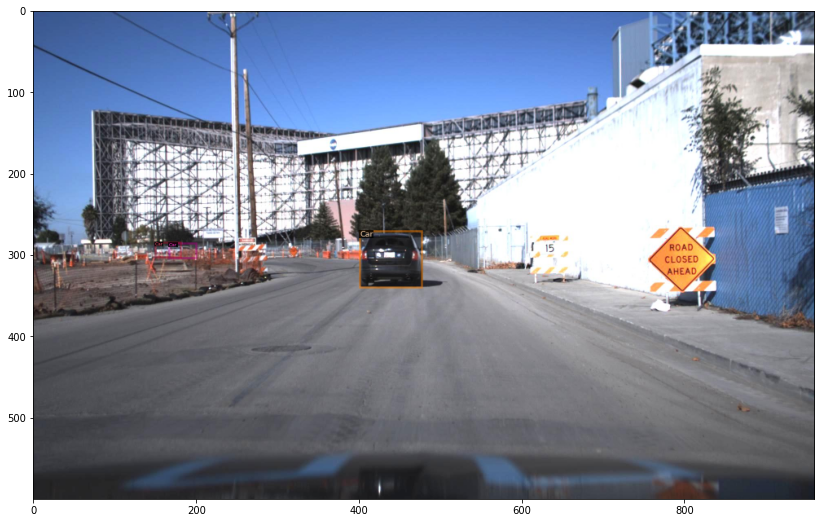

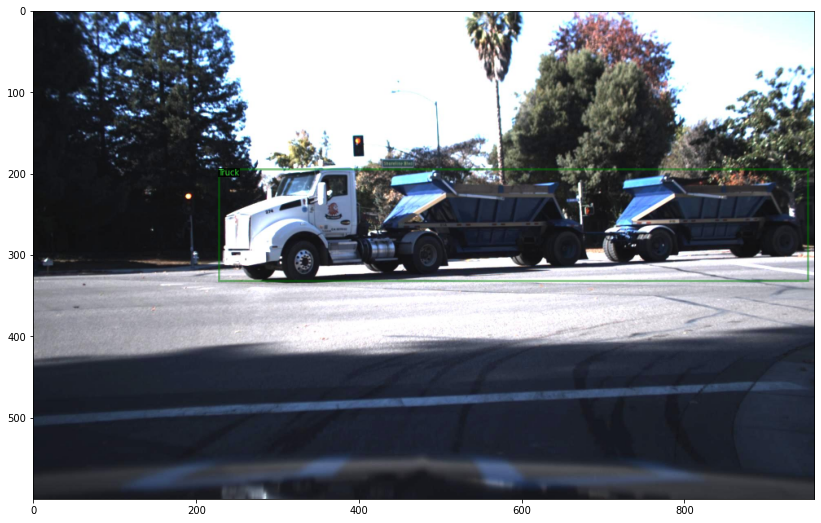

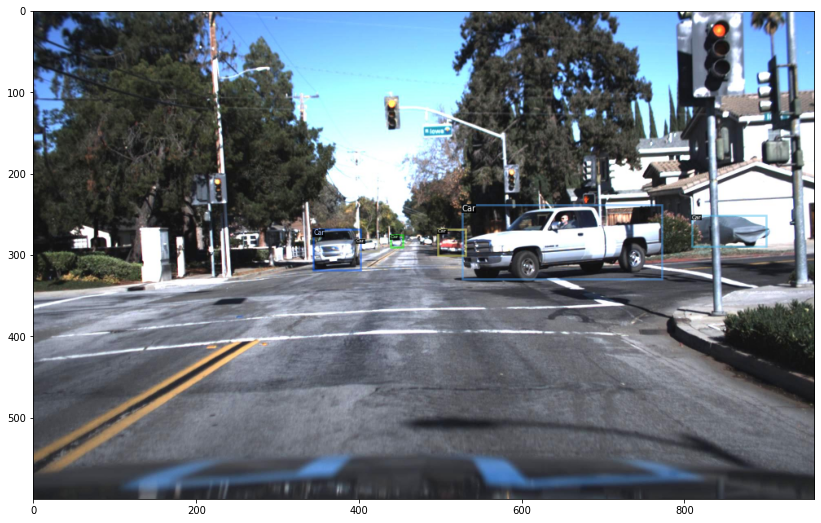

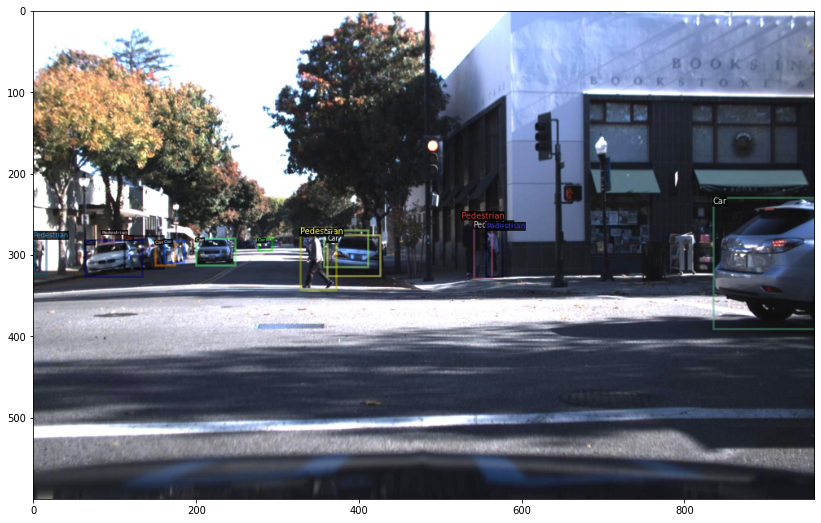

In [12]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

# **Train the Model**

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[05/06 09:50:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:22, 11.0MB/s]                           


[05/06 09:52:11 d2.engine.train_loop]: Starting training from iteration 0
[05/06 09:52:50 d2.utils.events]:  eta: 0:30:11  iter: 19  total_loss: 1.990  loss_cls: 1.263  loss_box_reg: 0.638  loss_rpn_cls: 0.025  loss_rpn_loc: 0.051  time: 1.9054  data_time: 0.0277  lr: 0.000400  max_mem: 3644M
[05/06 09:53:31 d2.utils.events]:  eta: 0:32:10  iter: 39  total_loss: 1.049  loss_cls: 0.374  loss_box_reg: 0.626  loss_rpn_cls: 0.017  loss_rpn_loc: 0.039  time: 1.9717  data_time: 0.0075  lr: 0.000799  max_mem: 3644M
[05/06 09:54:10 d2.utils.events]:  eta: 0:31:32  iter: 59  total_loss: 0.863  loss_cls: 0.251  loss_box_reg: 0.504  loss_rpn_cls: 0.012  loss_rpn_loc: 0.048  time: 1.9777  data_time: 0.0066  lr: 0.001199  max_mem: 3644M
[05/06 09:54:50 d2.utils.events]:  eta: 0:30:38  iter: 79  total_loss: 0.659  loss_cls: 0.220  loss_box_reg: 0.365  loss_rpn_cls: 0.023  loss_rpn_loc: 0.037  time: 1.9794  data_time: 0.0067  lr: 0.001598  max_mem: 3644M
[05/06 09:55:31 d2.utils.events]:  eta: 0:30:1

# **Inference Model**

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ('crowdai_vehicle_detection', )
predictor = DefaultPredictor(cfg)

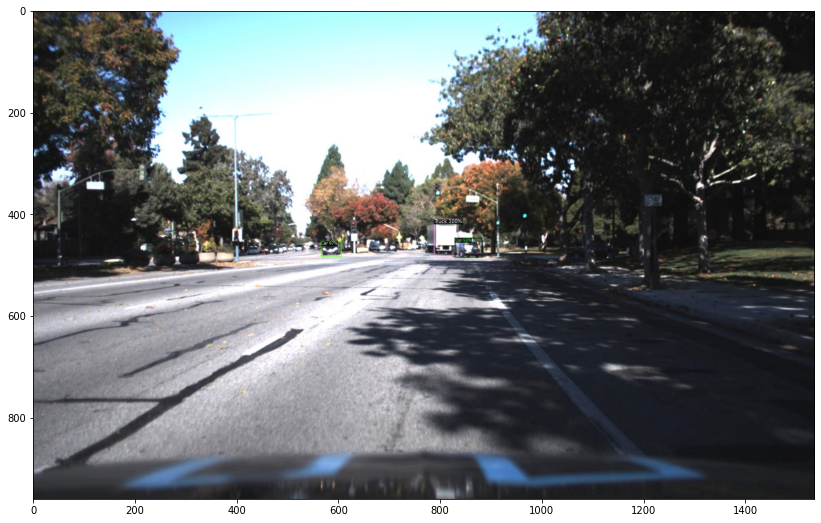

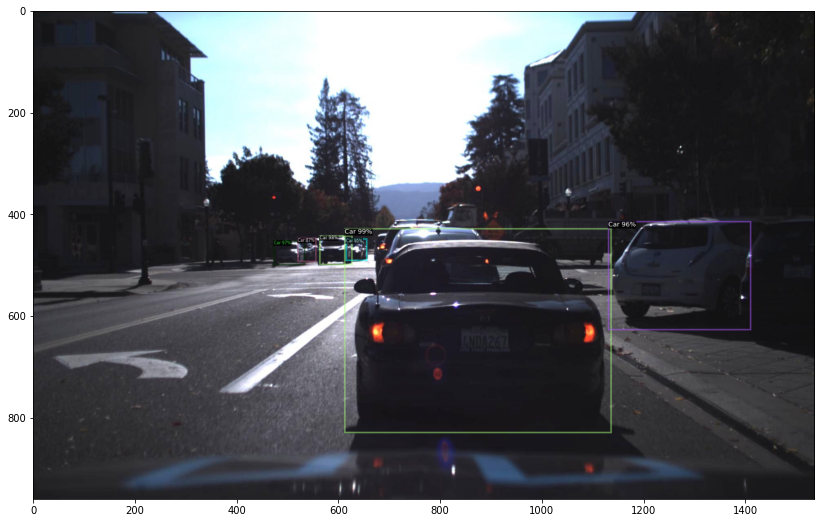

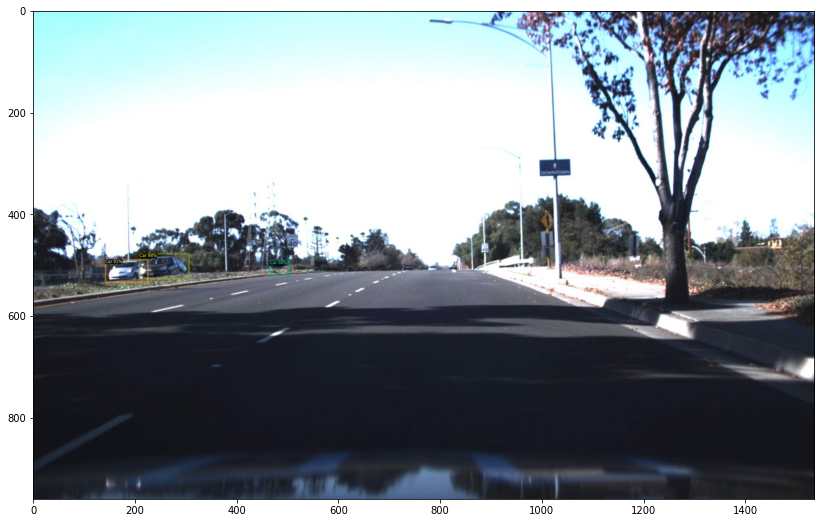

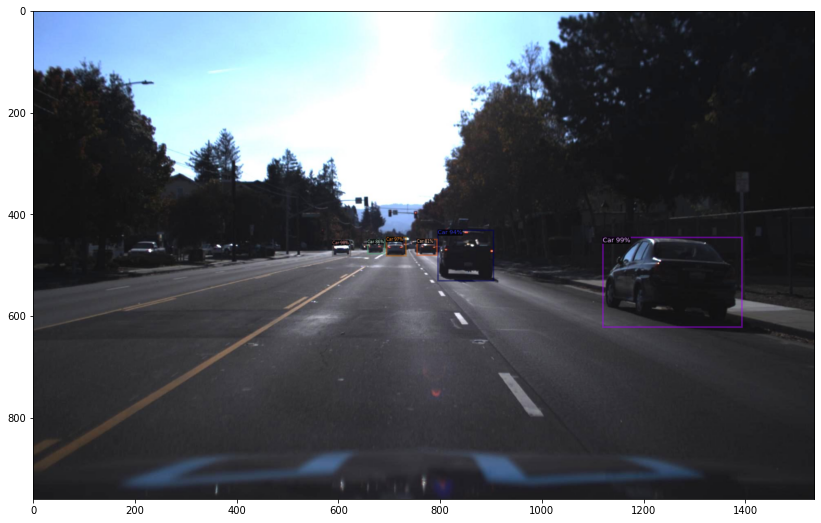

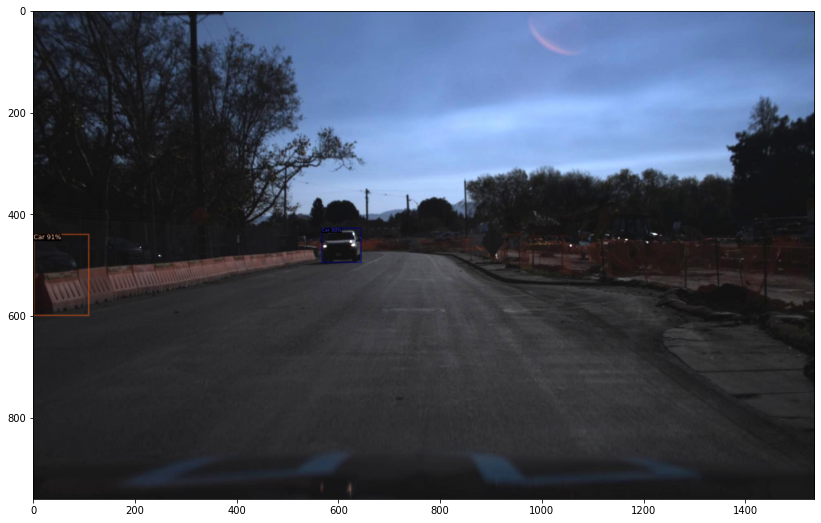

In [15]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()